In [2]:
%load_ext autoreload
%autoreload 2
from LHCB_Velo_Toy_Models.state_event_generator import *
from LHCB_Velo_Toy_Models import state_event_model 

import numpy as np
import matplotlib.pyplot as plt
from hhl_algorithm import HHLAlgorithm as hhl
from hhl_algorithm_1bit import HHLAlgorithm as hhl_1

In [49]:
dz = 20 #mm

n_particles=[2]#, 2, 2]#0, 20, 20, 20]
events = len(n_particles)
layers = 3

n = np.sum(n_particles)

module_id = [l for l in range(1, layers+1)]
lx = [33 for x in range(1, layers+1)]
ly = [33 for x in range(1, layers+1)]
zs = [dz*l for l in range(1, layers+1)]

Detector = state_event_model.PlaneGeometry(module_id=module_id,lx = lx,ly = ly,z = zs)
# Detector = state_event_model.RectangularVoidGeometry(module_id=module_id,lx = lx,ly = ly,z=zs, void_x_boundary=5, void_y_boundary=5)

state_event_gen = StateEventGenerator(Detector, events = len(n_particles), n_particles=n_particles,
                                       measurement_error=0.0, collision_noise=0.00)
state_event_gen.generate_random_primary_vertices(events, {'x': 0, 'y': 0, 'z': 0})

[(0, 0, 0.0)]

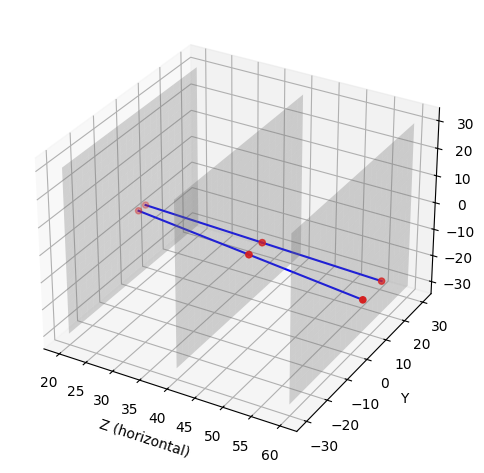

In [50]:
event_particles = []
for event in range(events):
    particles_list = []
    for particle in range(n):
        particle_dict = {
            'type' : 'MIP',
            'mass': 0.511,
            'q': 1
        }
        particles_list.append(particle_dict)
    event_particles.append(particles_list)

state_event_gen.generate_particles(event_particles)

event_tracks = state_event_gen.generate_complete_events()

event_tracks.plot_segments()

In [244]:
false_tracks = state_event_gen.make_noisy_event(drop_rate=0.0, ghost_rate=0.0)

In [245]:
false_tracks.plot_segments()

In [246]:
print(len(false_tracks.modules[0].hits))
print(len(event_tracks.modules[0].hits))

2
2


In [51]:
from LHCB_Velo_Toy_Models.simple_hamiltonian import SimpleHamiltonian

ham = SimpleHamiltonian(epsilon=1e-7, gamma=2.0, delta=1.0)

ham.construct_hamiltonian(event=event_tracks, convolution=False)
classical_solution = ham.solve_classicaly()
T = .45
discretized_classical_solution = (classical_solution > T).astype(int)
A = ham.A.todense()
print(np.shape(A))

(8, 8)


In [52]:

plt.matshow(A, cmap='gray')
plt.colorbar()
plt.title('Hamiltonian Matrix')
plt.show()

In [53]:
import scipy as sci
#rank_A = np.linalg.matrix_rank(A)
#print(f"\nRank of matrix A: {rank_A}")
print(np.abs(np.linalg.eigvals(A)))

[4. 2. 4. 2. 3. 3. 3. 3.]


In [ ]:
print("HHL Algorithm Implementation")
print("=" * 60)

matrix_A = A
vector_b = np.ones(len(A))

print("\nSolving Ax = b with:")
print("A =")
print(matrix_A)
print("b =")
print(vector_b)

from hhl_algorithm_1bit import add_suzuki_trotter_to_class
hhl_1 = add_suzuki_trotter_to_class(hhl_1)

# Create an instance of the HHL algorithm.
hhl_solver = hhl_1(matrix_A, vector_b, num_time_qubits=1, shots=10000)
circuit = hhl_solver.build_circuit()
print("\nHHL Circuit:")
print(circuit.draw(output="text"))

# Run the circuit.
counts = hhl_solver.run()
print("\nRaw Measurement Counts:")
print(counts)

# # Plot the histogram of all measurement results.
# hhl_solver.plot_results("hhl_results.png")

# Extract the HHL solution (trimmed to the original dimension).
x_hhl = hhl_solver.get_solution()
print("\nExtracted HHL solution (normalized):")
print(x_hhl)

# Compute the theoretical solution for comparison (using the original system, not the padded one).
x_exact = np.linalg.solve(matrix_A, vector_b)
#x_exact_normalized = x_exact / np.linalg.norm(x_exact)
print("\nTheoretical solution (normalized):")
print(x_exact)

HHL Algorithm Implementation

Solving Ax = b with:
A =
[[ 3.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  3.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  3.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  3.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  3.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  3.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  3.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  3.]]
b =
[1. 1. 1. 1. 1. 1. 1. 1.]
Patching HHLAlgorithm with Suzuki-Trotter methods...
0.0
4.0

HHL Circuit:
         ┌───┐           C-Trot(t=0.8)            ┌──────┐┌───┐         ┌───┐»
   time: ┤ H ├─────────────────■──────────────────┤ IQFT ├┤ X ├────■────┤ X ├»
         ├───┤┌────────────────┴─────────────────┐└──────┘└───┘    │    └───┘»
    b_0: ┤ H ├┤0                                 ├─────────────────┼─────────»
         ├───┤│                                  │                 │         »
    b_1: ┤ H ├┤1 exp(-it (III + XII + XZZ))(π/4) ├─────────────────┼─────────»
         ├───┤│                                  │                 │         »
    b_

<string>:14: RuntimeWarning: divide by zero encountered in scalar divide



Raw Measurement Counts:
{'1011': 185, '1111': 665, '1101': 187, '0011': 196, '0001': 611, '0101': 180, '1010': 1128, '1110': 570, '0100': 1084, '1100': 1053, '1000': 601, '0110': 639, '0000': 587, '0010': 1058, '1001': 641, '0111': 615}
Outcome: 1011, Count: 185
Outcome: 1111, Count: 665
Outcome: 1101, Count: 187
Outcome: 0011, Count: 196
Outcome: 0001, Count: 611
Outcome: 0101, Count: 180
Outcome: 1001, Count: 641
Outcome: 0111, Count: 615

Extracted HHL solution (normalized):
[0.43160223 0.2444506  0.23426064 0.4330127  0.44207107 0.23749198
 0.23877227 0.45027092]

Theoretical solution (normalized):
[0.5        0.33333333 0.33333333 0.5        0.5        0.33333333
 0.33333333 0.5       ]


In [ ]:
from LHCB_Velo_Toy_Models.simple_hamiltonian import get_tracks

truth_event = false_tracks
rec_tracks = get_tracks(ham, discretized_classical_solution, false_tracks) 

from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl
validator = evl(truth_event, rec_tracks)
validator.print_metrics()

In [ ]:
'''from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='20caa5a0277cbbb8949d9d9dbe38669d2a916493d36b2920d6d9d6d409addc73167334f2a5ec06736887b565c2c0f20aabc250aa773f6dcaef80e10fd68ce5a6'
)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='<IBM Quantum API key>')
backend = service.least_busy(min_num_qubits=circuit.num_qubits, simulator=False, operational=True)
print(f"Found device: '{backend.name}'")
print(f"Status: {backend.status().status_msg}, Qubits: {backend.num_qubits}, Pending Jobs: {backend.status().pending_jobs}")'''

'from qiskit_ibm_runtime import QiskitRuntimeService\n\nservice = QiskitRuntimeService(\n    channel=\'ibm_quantum\',\n    instance=\'ibm-q/open/main\',\n    token=\'20caa5a0277cbbb8949d9d9dbe38669d2a916493d36b2920d6d9d6d409addc73167334f2a5ec06736887b565c2c0f20aabc250aa773f6dcaef80e10fd68ce5a6\'\n)\n\n# Or save your credentials on disk.\n# QiskitRuntimeService.save_account(channel=\'ibm_quantum\', instance=\'ibm-q/open/main\', token=\'<IBM Quantum API key>\')\nbackend = service.least_busy(min_num_qubits=circuit.num_qubits, simulator=False, operational=True)\nprint(f"Found device: \'{backend.name}\'")\nprint(f"Status: {backend.status().status_msg}, Qubits: {backend.num_qubits}, Pending Jobs: {backend.status().pending_jobs}")'

In [1]:
import os
from qiskit import transpile
from qiskit.visualization import plot_histogram
# The new pattern uses SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# Make sure a QuantumCircuit object named 'circuit' exists from your previous cell.
if 'circuit' not in locals():
    raise NameError("A Qiskit QuantumCircuit object named 'circuit' was not found. Please run your HHL code cell first.")

print("--- Step 1: Connecting to IBM Quantum using IBM Cloud Channel ---")
try:
    # This will load your saved IBM Cloud credentials.
    # Make sure you have run QiskitRuntimeService.save_account(channel='ibm_cloud', ...)
    service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='20caa5a0277cbbb8949d9d9dbe38669d2a916493d36b2920d6d9d6d409addc73167334f2a5ec06736887b565c2c0f20aabc250aa773f6dcaef80e10fd68ce5a6')
    print("Successfully connected to the Qiskit Runtime Service.")
except Exception as e:
    print(f"Failed to connect: {e}")
    print("Please ensure you have saved your IBM Cloud API Key and CRN.")

if 'service' in locals():
    print("\n--- Step 2: Finding the Best Available Device ---")
    # Find the least busy backend that is not a simulator and has enough qubits
    backend = service.least_busy(min_num_qubits=circuit.num_qubits, simulator=False, operational=True)
    print(f"Found device: '{backend.name}'")
    print(f"Status: {backend.status().status_msg}, Qubits: {backend.num_qubits}, Pending Jobs: {backend.status().pending_jobs}")

    print("\n--- Step 3: Estimating Circuit Depth and Gate Counts ---")
    print(f"Transpiling circuit for '{backend.name}'...")

    # Transpile the circuit for the specific hardware backend
    transpiled_circuit = transpile(circuit, backend=backend, optimization_level=3, translation_method='translator')

    print("\n--- Comparison of Circuit Metrics ---")
    print(f"Transpiled Circuit Depth (for '{backend.name}'): {transpiled_circuit.depth()}")
    print(f"Transpiled Gate Counts: {transpiled_circuit.count_ops()}")
    print("-" * 40)

    print("\n--- Step 4: Running the Circuit using SamplerV2 ---")
    print("WARNING: This will submit a job to the IBM Quantum cloud.")
    
    # Add measurements if your circuit doesn't have them
    if transpiled_circuit.num_clbits == 0:
        print("Adding measurement gates to the circuit...")
        transpiled_circuit.measure_all(inplace=True)

    # --- MODIFIED CODE BLOCK for SamplerV2 ---
    # 1. Instantiate the Sampler with the chosen backend
    sampler = Sampler(mode=backend)
    
    # 2. Submit the job by calling sampler.run()
    #    The 'shots' count is passed as a direct argument.
    job = sampler.run([transpiled_circuit], shots=16384)
    # --- END MODIFICATION ---
    
    print(f"Job submitted successfully. Job ID: {job.job_id}")
    print(f"You can monitor the job status here: https://quantum.ibm.com/jobs/{job.job_id}")
    
    print("\nWaiting for job to complete... (This can take a long time)")
    result = job.result()
    
    print("\nJob finished!")
    # The V2 result object contains the data in a pub_result (Primitive Unified Bloc Result)
    # We access the counts from the data field of the first result.
    pub_result = result[0]
    counts = pub_result.data.c.get_counts()

    print("\n--- Measurement Results from Hardware ---")
    print(counts)
    plot_histogram(counts)

NameError: A Qiskit QuantumCircuit object named 'circuit' was not found. Please run your HHL code cell first.

In [272]:
x_hhl = hhl_solver.get_solution(counts)
print("\nExtracted HHL solution (normalized):")
print(x_hhl)

Outcome: 1101, Count: 1081
Outcome: 0111, Count: 910
Outcome: 1111, Count: 890
Outcome: 1011, Count: 956
Outcome: 1001, Count: 1559
Outcome: 0011, Count: 1020
Outcome: 0001, Count: 1583
Outcome: 0101, Count: 1253

Extracted HHL solution (normalized):
[0.41364011 0.33203378 0.36800839 0.31361937 0.41049252 0.3214483
 0.34181808 0.31015386]


In [254]:
x_exact_disc = (x_exact > 0.4).astype(int)
x_hhl_disc = (x_hhl > 0.0).astype(int)

num_matches = np.sum(x_exact_disc == x_hhl_disc)
total_elements = len(x_exact_disc)
similarity_accuracy = num_matches / total_elements
print(f"Similarity (Accuracy): {similarity_accuracy:.4f}")

from scipy.spatial.distance import hamming
hamming_distance_norm_scipy = hamming(x_exact_disc, x_hhl_disc)
print(f"Hamming Distance: {hamming_distance_norm_scipy:.4f}")

Similarity (Accuracy): 1.0000
Hamming Distance: 0.0000


In [255]:
circuit_depth = circuit.decompose().decompose().decompose().decompose().decompose().decompose().count_ops()
circuit_depth

OrderedDict([('u', 276), ('cx', 146), ('measure', 4)])

--- INSIDE analyze_solution_spectrum ---
Initial shape of matrix_A: (8, 8)
Initial shape of vector_b: (8,)
Shape of vector_b after flattening: (8,)
-------------------------------------

--- Loop iteration i=0 ---
Eigenvalue (key): 4.00
Shape of component_solutions[key] (left side of +=): (8,)
Shape of component (right side of +=):            (8,)
4.0
[ 0.70710678  0.          0.          0.         -0.70710678  0.
  0.          0.        ]
...addition successful.

--- Loop iteration i=1 ---
Eigenvalue (key): 2.00
Shape of component_solutions[key] (left side of +=): (8,)
Shape of component (right side of +=):            (8,)
2.0
[0.70710678 0.         0.         0.         0.70710678 0.
 0.         0.        ]
...addition successful.

--- Loop iteration i=2 ---
Eigenvalue (key): 4.00
Shape of component_solutions[key] (left side of +=): (8,)
Shape of component (right side of +=):            (8,)
4.0
[ 0.          0.          0.         -0.70710678  0.          0.
  0.          0.7071067

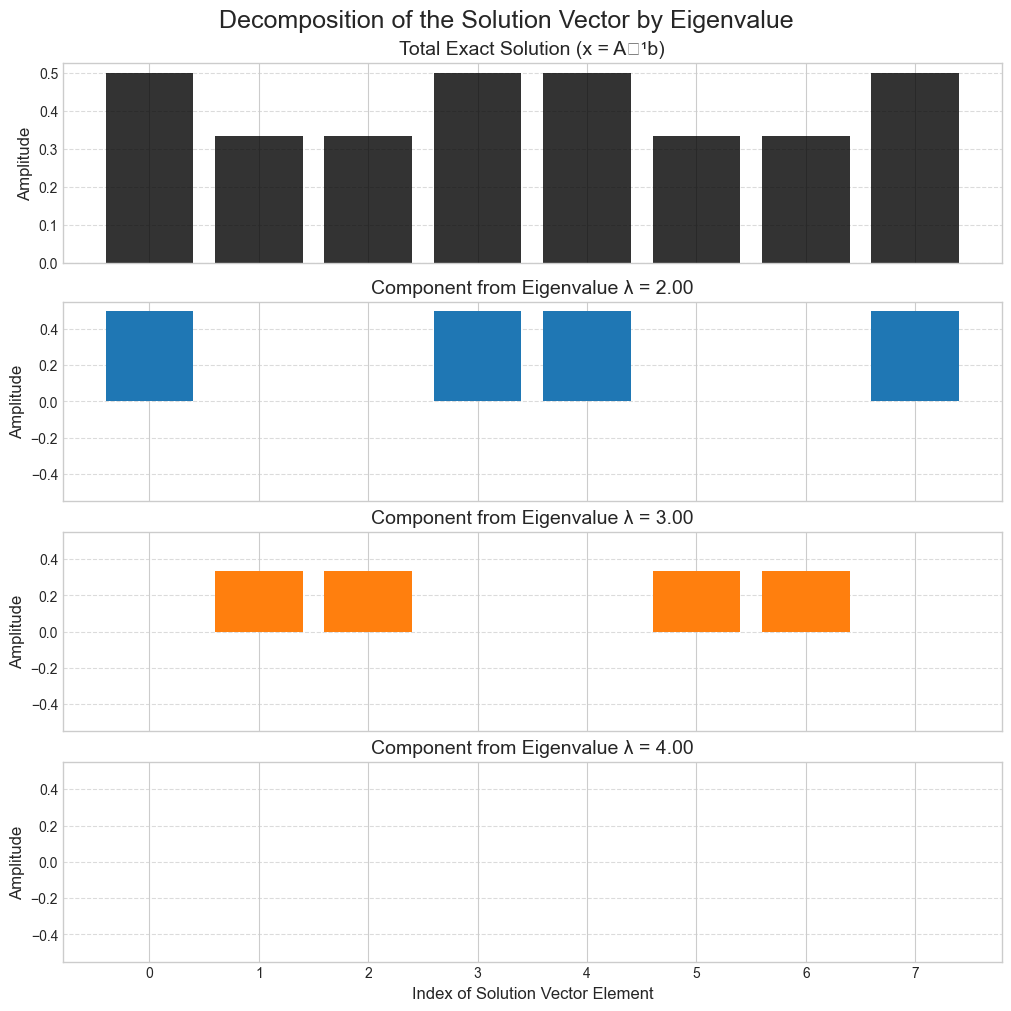

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_solution_spectrum(matrix_A, vector_b):
    """
    Classically computes the exact solution to Ax=b and decomposes it
    into components based on the eigenvalues of A, with added debugging prints.
    """++
    print("--- INSIDE analyze_solution_spectrum ---")
    print(f"Initial shape of matrix_A: {matrix_A.shape}")
    print(f"Initial shape of vector_b: {vector_b.shape}")

    # --- ROBUSTNESS FIX ---
    # Ensure the input vector is a 1D array ('flattened').
    vector_b = vector_b.flatten()
    print(f"Shape of vector_b after flattening: {vector_b.shape}")
    print("-------------------------------------\n")


    if matrix_A.shape[0] != matrix_A.shape[1]:
        raise ValueError("Matrix A must be square.")
    if matrix_A.shape[0] != len(vector_b):
        raise ValueError("Matrix and vector dimensions must match.")

    # Eigendecomposition
    eig_vals, eig_vecs = np.linalg.eig(matrix_A)
    #print('Eingenvalues:', eig_vals)
    #print('Eingenvectors:', eig_vecs)
    # Change of basis
    betas = np.linalg.inv(eig_vecs) @ vector_b

    # Prepare for component calculation
    unique_eigenvalues = np.unique(np.round(eig_vals, 5))
    component_solutions = {lam: np.zeros_like(vector_b, dtype=complex) for lam in unique_eigenvalues}

    # Calculate individual solution components
    for i in range(len(eig_vals)):
        lam = eig_vals[i]
        beta = betas[i]
        u_vec = eig_vecs[:, i]
        
        key = unique_eigenvalues[np.argmin(np.abs(unique_eigenvalues - lam))]
        
        if abs(lam) > 1e-9:
            component = (beta / lam) * u_vec
            
            # --- DEBUGGING PRINT STATEMENTS ---
            print(f"--- Loop iteration i={i} ---")
            print(f"Eigenvalue (key): {key:.2f}")
            print(f"Shape of component_solutions[key] (left side of +=): {component_solutions[key].shape}")
            print(f"Shape of component (right side of +=):            {component.shape}")
            print(lam)
            print(u_vec)
            
            # This is the line that causes the error
            component_solutions[key] += component
            
            print("...addition successful.\n")


    # Calculate the total solution for comparison
    total_exact_solution = np.linalg.solve(matrix_A, vector_b)

    # Plotting
    num_plots = len(unique_eigenvalues) + 1
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, num_plots * 2.5), sharex=True, constrained_layout=True)
    fig.suptitle('Decomposition of the Solution Vector by Eigenvalue', fontsize=18)

    axes[0].bar(range(len(total_exact_solution)), total_exact_solution.real, color='black', alpha=0.8)
    axes[0].set_title('Total Exact Solution (x = A⁻¹b)', fontsize=14)
    axes[0].set_ylabel('Amplitude', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    plot_idx = 1
    max_comp_amp = max([np.max(np.abs(comp.real)) for comp in component_solutions.values()] + [0])
    if max_comp_amp == 0: max_comp_amp = 1.0

    for lam, component_vec in sorted(component_solutions.items()):
        ax = axes[plot_idx]
        ax.bar(range(len(component_vec)), component_vec.real, color=f'C{plot_idx-1}')
        ax.set_title(f'Component from Eigenvalue λ = {lam:.2f}', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_ylim(-max_comp_amp * 1.1, max_comp_amp * 1.1)
        plot_idx += 1

    axes[-1].set_xlabel('Index of Solution Vector Element', fontsize=12)
    plt.show()

    
analyze_solution_spectrum(np.array(matrix_A), np.array(vector_b))

In [257]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit import transpile

# Assume 'circuit' is your fully built QuantumCircuit object from hhl_solver.build_circuit()

print("\n--- Transpiling for a specific IBM Quantum device ---")

# 1. Load a realistic model of the target backend.
# FakeSherbrooke mimics the real 127-qubit device's properties.

backend = FakeSherbrooke()
print(f"Loaded realistic model for: {backend.name}")
print(f"Number of qubits: {backend.configuration().n_qubits}")
print(f"Basis gates: {backend.configuration().basis_gates}")

# 2. Transpile the circuit for the backend with high optimization.
# The transpiler will now account for the specific gate set and qubit connectivity.
print("\nTranspiling... (This may take a moment for a large circuit)")
transpiled_circuit_sherbrooke = transpile(circuit, backend=backend, optimization_level=3)

# 3. Analyze the new, hardware-aware circuit
real_depth = transpiled_circuit_sherbrooke.depth()
real_gate_counts = transpiled_circuit_sherbrooke.count_ops()

print("\n--- Results for ibm_sherbrooke ---")
print(f"Real Circuit Depth: {real_depth}")
print("Real Gate Counts:", real_gate_counts)


# Assume 'circuit' and 'backend' (e.g., FakeSherbrooke) exist

print("--- Searching for a better transpilation seed ---")
best_circuit = None
best_depth = float('inf')

for seed in range(5): # Try 5 different random seeds
	print(f"Trying seed_transpiler = {seed}...")
	transpiled = transpile(circuit, 
						backend=backend, 
						optimization_level=3,
						layout_method='sabre', # Explicitly state the method
						routing_method='sabre',
						seed_transpiler=seed) # Use a different seed each time
	
	current_depth = transpiled.depth()
	print(f"  -> Achieved depth: {current_depth}")
	
	if current_depth < best_depth:
		best_depth = current_depth
		best_circuit = transpiled

print(f"\nBest depth found after 5 attempts: {best_depth}")
print("Gate counts for best circuit:", best_circuit.count_ops())


--- Transpiling for a specific IBM Quantum device ---
Loaded realistic model for: fake_sherbrooke
Number of qubits: 127
Basis gates: ['ecr', 'id', 'rz', 'sx', 'x']

Transpiling... (This may take a moment for a large circuit)

--- Results for ibm_sherbrooke ---
Real Circuit Depth: 898
Real Gate Counts: OrderedDict({'rz': 728, 'sx': 459, 'ecr': 242, 'x': 46, 'measure': 4})
--- Searching for a better transpilation seed ---
Trying seed_transpiler = 0...
  -> Achieved depth: 924
Trying seed_transpiler = 1...
  -> Achieved depth: 937
Trying seed_transpiler = 2...
  -> Achieved depth: 953
Trying seed_transpiler = 3...
  -> Achieved depth: 914
Trying seed_transpiler = 4...
  -> Achieved depth: 911

Best depth found after 5 attempts: 911
Gate counts for best circuit: OrderedDict({'rz': 745, 'sx': 457, 'ecr': 258, 'x': 38, 'measure': 4})


In [258]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector

# --- 1. Setup the Circuit ---
# We need 3 main qubits and 1 ancilla qubit to act as our workspace
num_main_qubits = 3
main_register = QuantumRegister(num_main_qubits, name='main')
ancilla = QuantumRegister(1, name='ancilla')
qc = QuantumCircuit(main_register, ancilla)


# --- 2. Step A: Create the perfect superposition ---
qc.h(main_register)
qc.barrier(label="Initial Superposition")
qc.x(main_register)
qc.mcry(np.pi, main_register, ancilla[0])
qc.x(main_register)
qc.barrier(label="Remove |000> Amp")


# --- 4. Verify the Result with the Statevector ---
# We will look at the final 4-qubit statevector to see what happened.
print("--- All 16 Final States of the 4-Qubit System ---")
sv = Statevector(qc)

print(qc.decompose().decompose().decompose().count_ops())
# Qiskit's statevector format is |q3,q2,q1,q0> = |ancilla, main_2, main_1, main_0>
print("State |ancilla, main>  | Amplitude")
print("--------------------|----------------------")

# Loop through all 16 possible states and print their amplitude
for i, amp in enumerate(sv.data):
    # Format the basis state from its index 'i' to a 4-bit binary string
    basis_state = f"|{i:04b}>"
    # Print the amplitude, whether it's zero or not
    print(f"   {basis_state}         | {amp.real:.4f} + {amp.imag:.4f}j")

--- All 16 Final States of the 4-Qubit System ---
OrderedDict({'u': 44, 'cx': 20, 'barrier': 2})
State |ancilla, main>  | Amplitude
--------------------|----------------------
   |0000>         | -0.0000 + 0.0000j
   |0001>         | 0.3536 + 0.0000j
   |0010>         | 0.3536 + 0.0000j
   |0011>         | 0.3536 + 0.0000j
   |0100>         | 0.3536 + 0.0000j
   |0101>         | 0.3536 + 0.0000j
   |0110>         | 0.3536 + 0.0000j
   |0111>         | 0.3536 + 0.0000j
   |1000>         | 0.3536 + 0.0000j
   |1001>         | 0.0000 + 0.0000j
   |1010>         | -0.0000 + 0.0000j
   |1011>         | 0.0000 + 0.0000j
   |1100>         | -0.0000 + 0.0000j
   |1101>         | -0.0000 + 0.0000j
   |1110>         | -0.0000 + 0.0000j
   |1111>         | 0.0000 + 0.0000j


In [259]:


from collections import Counter
# =============================================================================
# --- CORRECTED CODE: Finding and Applying a Smart Initial Layout ---
# =============================================================================

# Assume 'circuit' is your fully built QuantumCircuit object

# --- Analysis Step 1: Find virtual qubit interactions ---
print("\n--- Analyzing virtual circuit interactions ---")

# Decompose the circuit to see the underlying CNOTs
decomposed_circuit = circuit.decompose()

# Count the occurrences of each two-qubit interaction
# FIX: Use circuit.find_bit(qubit).index to get the qubit's overall index
cx_pairs = []
for instruction in decomposed_circuit.data:
	if instruction.operation.name == 'cx':
		# Get the Qubit objects
		q1_obj, q2_obj = instruction.qubits
		# Find their indices within the circuit
		q1_index = decomposed_circuit.find_bit(q1_obj).index
		q2_index = decomposed_circuit.find_bit(q2_obj).index
		# Store as a sorted tuple
		cx_pairs.append(tuple(sorted((q1_index, q2_index))))

# Display the most frequent interactions
interaction_counts = Counter(cx_pairs)
print("Top 5 virtual qubit interactions (virtual qubit indices):")
for pair, count in interaction_counts.most_common(5):
	print(f"  Qubits {pair}: {count} times")

#from qiskit.visualization import plot_gate_map

# --- Analysis Step 2: Visualize hardware connectivity ---
#print("\n--- Visualizing ibm_sherbrooke connectivity ---")

#backend = FakeSherbrooke()
# This plot will show you the physical layout of the 127 qubits.
# Each line represents a possible CNOT connection.
#plot_gate_map(backend, plot_directed=True, figsize=(12, 12))
#print("Generated 'ibm_sherbrooke_layout.png' to show physical qubit connections.")
#fig.savefig("ibm_sherbrooke_layout.png")
#plt.close(fig) # Close the figure to prevent it from displaying immediately
#plt.show()



--- Analyzing virtual circuit interactions ---
Top 5 virtual qubit interactions (virtual qubit indices):
  Qubits (1, 4): 4 times
  Qubits (0, 4): 4 times
  Qubits (0, 1): 2 times


In [262]:
import numpy as np
import math
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT, RYGate, UnitaryGate
from scipy.linalg import expm

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter

def add_suzuki_trotter_to_class(HHLAlgorithmClass):
    
    def _create_trotter_gate(self, evolution_time, trotter_steps=1, order=0):
        if not hasattr(self, '_pauli_A'):
            self._pauli_A = SparsePauliOp.from_operator(self.A)

        if order == 1:
            synthesis_method = LieTrotter(reps=trotter_steps)
        if order == 0:
            synthesis_method = QDrift(reps=trotter_steps)
        else:
            synthesis_method = SuzukiTrotter(reps=trotter_steps, order=2)

        trotter_gate = PauliEvolutionGate(self._pauli_A, 
                                          time=evolution_time, 
                                          synthesis=synthesis_method)
        return trotter_gate

    def _apply_trotter_controlled_u(self, qc, control_qubit, target_qubits, power, trotter_steps=1, order=2):
        evolution_time = self.t * power
        trotter_gate = self._create_trotter_gate(evolution_time, trotter_steps, order)
        controlled_trotter = trotter_gate.control(1, label=f"C-Trot(t={evolution_time:.1f})")
        qc.append(controlled_trotter, [control_qubit] + target_qubits)

    # Replace the class's original apply_controlled_u with our new one
    print("Patching HHLAlgorithm with Suzuki-Trotter methods...")
    HHLAlgorithmClass._create_trotter_gate = _create_trotter_gate
    HHLAlgorithmClass.apply_controlled_u = _apply_trotter_controlled_u
    
    return HHLAlgorithmClass

class HHLAlgorithm:
    def __init__(self, matrix_A, vector_b, num_time_qubits=5, shots=1024, debug=False):
        A = matrix_A
        self.original_dim = A.shape[0]
        self.debug = debug

        d = self.original_dim
        n_needed = math.ceil(np.log2(d))
        padded_dim = 2 ** n_needed

        if padded_dim != d:
            A_padded = np.zeros((padded_dim, padded_dim), dtype=complex)
            A_padded[:d, :d] = A
            A = (A_padded + A_padded.conj().T) / 2

            b_padded = np.zeros(padded_dim, dtype=complex)
            b_padded[:d] = vector_b
            vector_b = b_padded

        b_normalized = vector_b / np.linalg.norm(vector_b)

        self.A_orig = A.copy()
        self.A_norm = np.linalg.norm(A)
        A = A / self.A_norm

        self.A = A
        self.vector_b = b_normalized
        self.num_time_qubits = num_time_qubits
        self.shots = shots

        self.system_dim = A.shape[0]
        self.num_system_qubits = int(np.log2(self.system_dim))

        self.time_qr = QuantumRegister(self.num_time_qubits, "time")
        self.b_qr = QuantumRegister(self.num_system_qubits, "b")
        self.ancilla_qr = QuantumRegister(1, "ancilla")
        self.classical_reg = ClassicalRegister(1 + self.num_system_qubits, "c")

        self.circuit = None
        self.counts = None

        self.t = np.pi / np.max(np.abs(np.linalg.eigvals(A)))
        self.eigenvalues = np.linalg.eigvals(self.A_orig)
        self.eigenvalues_scaled = np.linalg.eigvals(self.A)

    def create_input_state(self):
        qc_b = QuantumCircuit(self.num_system_qubits)
        qc_b.initialize(self.vector_b, list(range(self.num_system_qubits)))
        return qc_b

    def apply_controlled_u(self, qc, matrix, control, target, power):
        U = expm(1j * matrix * self.t * power)
        controlled_U = UnitaryGate(U).control(1)
        qc.append(controlled_U, [control] + target)
        return qc

    def inverse_qft(self, n_qubits):
        return QFT(n_qubits, do_swaps=True).inverse()

    def phase_estimation(self, qc):
        for qubit in self.time_qr:
            qc.h(qubit)

        for i in range(self.num_time_qubits):
            power = 2 ** i
            self.apply_controlled_u(qc, self.time_qr[self.num_time_qubits - i - 1], list(self.b_qr), power)

        iqft = self.inverse_qft(self.num_time_qubits).to_gate(label="IQFT")
        qc.append(iqft, self.time_qr[:])

    def uncompute_phase_estimation(self, qc):
        qft = QFT(self.num_time_qubits, do_swaps=True).to_gate(label="QFT")
        qc.append(qft, self.time_qr[:])

        for i in reversed(range(self.num_time_qubits)):
            power = 2 ** i
            self.apply_controlled_u(qc, self.time_qr[self.num_time_qubits - i - 1], list(self.b_qr), power)

        for qubit in self.time_qr:
            qc.h(qubit)

    def build_circuit(self):
        qc = QuantumCircuit(self.time_qr, self.b_qr, self.ancilla_qr, self.classical_reg)

        #qc.compose(self.create_input_state(), qubits=list(self.b_qr), inplace=True)
        for qubit in self.b_qr:
            qc.h(qubit)
            

        self.phase_estimation(qc)

        gain = 0.3
        #n_time = self.num_time_qubits
        for i in range(2 ** self.num_time_qubits):
            #phase = i / (2 ** n_time)
            #if phase >= 0.5:
            #    phase = phase - 1.0

            phase = i / (2 ** self.num_time_qubits)
            lam = 2 * np.pi * phase / self.t
            if abs(lam) > 0.4: #1e-9:# or abs(lam) > 10.0:
                continue

            inv_lam = 1.0 / lam
            angle = 2 * np.arcsin(min(1, gain * inv_lam / 2))
            controls = list(self.time_qr)

            bits = format(i, f"0{self.num_time_qubits}b")
            for j, bit in enumerate(bits):
                if bit == '0':
                    qc.x(self.time_qr[j])

            cry = RYGate(angle).control(num_ctrl_qubits=self.num_time_qubits)
            qc.append(cry, [*controls, self.ancilla_qr[0]])

            for j, bit in enumerate(bits):
                if bit == '0':
                    qc.x(self.time_qr[j])

        self.uncompute_phase_estimation(qc)

        qc.measure(self.ancilla_qr[0], self.classical_reg[0])
        qc.measure(self.b_qr, self.classical_reg[1:])

        self.circuit = qc
        return qc

    def run(self):
        simulator = AerSimulator()
        transpiled_circuit = transpile(self.circuit, simulator, optimization_level=3)
        job = simulator.run(transpiled_circuit, shots=self.shots)
        result = job.result()
        self.counts = result.get_counts()
        return self.counts

    def get_solution(self):
        if self.counts is None:
            raise ValueError("No measurement results available. Run run() first.")

        total_success = 0
        padded_dim = 2 ** self.num_system_qubits
        prob_dist = np.zeros(padded_dim)

        for outcome, count in self.counts.items():
            if outcome[-1] == '1':
                print(f"Outcome: {outcome}, Count: {count}")
                #print(outcome[:-1])
                system_bits = outcome[:-1]#[::-1]
                #print(f"System bits: {system_bits}")
                index = int(system_bits, 2)
                prob_dist[index] += count
                total_success += count

        if total_success == 0:
            print("No valid solution: ancilla was never measured as |1⟩.")
            return None

        prob_dist = prob_dist / total_success
        solution_padded = np.sqrt(prob_dist)
        solution_padded = solution_padded / np.linalg.norm(solution_padded)

        solution_vector = solution_padded[:self.original_dim]
        solution_vector = solution_vector / np.linalg.norm(solution_vector)
        #solution_vector = solution_vector / self.A_norm
        return solution_vector

    def plot_results(self, filename="hhl_results.png"):
        if self.counts is None:
            raise ValueError("No measurement results available. Run run() first.")
        plot_histogram(self.counts)
        plt.title("HHL Algorithm Results")
        plt.savefig(filename)
        print(f"Results histogram saved as '{filename}'.")

    def simulate_statevector(self):
        from qiskit_aer import Aer
        backend = Aer.get_backend("statevector_simulator")
        job = backend.run(transpile(self.circuit, backend))
        statevector = job.result().get_statevector()
        return statevector

    def extract_postselected_solution(self, statevector):
        dim = 2 ** (self.num_time_qubits + self.num_system_qubits + 1)
        total_qubits = self.num_time_qubits + self.num_system_qubits + 1
        system_qubits = self.num_system_qubits
        ancilla_index = self.num_time_qubits + self.num_system_qubits

        probs = np.abs(statevector.data) ** 2
        sol = np.zeros(2 ** system_qubits)

        for i, amp in enumerate(statevector.data):
            if ((i >> ancilla_index) & 1) == 1:
                system_state = (i >> 0) & ((1 << system_qubits) - 1)
                sol[system_state] += np.abs(amp) ** 2

        sol = np.sqrt(sol)
        sol = sol / np.linalg.norm(sol)
        return sol



In [263]:
'''hhl_1 = add_suzuki_trotter_to_class(hhl_1)

hhl_solver = hhl_1(matrix_A, vector_b, num_time_qubits=2, shots=8192, debug=True)
circuit = hhl_solver.build_circuit()
print(circuit.draw(output="text"))
counts = hhl_solver.run()
print('counts:', counts)
#hhl_solver.plot_results("hhl_results.png")
x_hhl = hhl_solver.get_solution()
print("\nHHL Solution:", x_hhl)

x_exact = np.linalg.solve(matrix_A, vector_b)
x_exact_normalized = x_exact / np.linalg.norm(x_exact)
print("\nExact Solution:", x_exact_normalized)

if x_hhl is not None:
	fidelity = np.abs(np.vdot(x_hhl, x_exact_normalized))
	print(f"\nFidelity with exact solution: {fidelity:.4f}")

circuit_depth = circuit.decompose().decompose().decompose().decompose().decompose().decompose().depth()
gate_statistics = circuit.decompose().decompose().decompose().decompose().decompose().decompose().count_ops()
print(f"The depth of the quantum circuit is: {circuit_depth}")
print("Gate statistics for the circuit:")
print(gate_statistics)

#print("\nEigenvalues of original A:", np.round(hhl_solver.eigenvalues, 4))
#print("Eigenvalues of scaled A (used in phase estimation):", np.round(hhl_solver.eigenvalues_scaled, 4))

#print("\n[Debug] Running ideal statevector simulation...")
statevector = hhl_solver.simulate_statevector()
#print("Final statevector (truncated):", statevector.data[:8])

post_selected = hhl_solver.extract_postselected_solution(statevector)
#print("\nPostselected solution from statevector:", post_selected)
fidelity_post = np.abs(np.vdot(post_selected, x_exact_normalized))
#print(f"Fidelity (postselected vs exact): {fidelity_post:.4f}")'''


'hhl_1 = add_suzuki_trotter_to_class(hhl_1)\n\nhhl_solver = hhl_1(matrix_A, vector_b, num_time_qubits=2, shots=8192, debug=True)\ncircuit = hhl_solver.build_circuit()\nprint(circuit.draw(output="text"))\ncounts = hhl_solver.run()\nprint(\'counts:\', counts)\n#hhl_solver.plot_results("hhl_results.png")\nx_hhl = hhl_solver.get_solution()\nprint("\nHHL Solution:", x_hhl)\n\nx_exact = np.linalg.solve(matrix_A, vector_b)\nx_exact_normalized = x_exact / np.linalg.norm(x_exact)\nprint("\nExact Solution:", x_exact_normalized)\n\nif x_hhl is not None:\n\tfidelity = np.abs(np.vdot(x_hhl, x_exact_normalized))\n\tprint(f"\nFidelity with exact solution: {fidelity:.4f}")\n\ncircuit_depth = circuit.decompose().decompose().decompose().decompose().decompose().decompose().depth()\ngate_statistics = circuit.decompose().decompose().decompose().decompose().decompose().decompose().count_ops()\nprint(f"The depth of the quantum circuit is: {circuit_depth}")\nprint("Gate statistics for the circuit:")\nprint(ga

In [264]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Define the Parameters for Each Filter ---
# --- Play with these values to see how the curves change! ---

# 1. Hard Threshold Filter
HARD_THRESHOLD = 0.6

# 2. Standard HHL Filter (1/lambda)
# This gain constant is needed to keep the amplitude <= 1
HHL_GAIN = 0.4

# 3. Smooth Sigmoid Filter
SIGMOID_CENTER = 0.5  # The center of the transition
SIGMOID_STEEPNESS = 25  # A larger value makes the transition sharper

# 4. Gaussian Peak Filter
GAUSSIAN_TARGET = 0.75 # The eigenvalue we want to isolate
GAUSSIAN_SIGMA = 0.1   # A smaller sigma makes the peak narrower


# --- Step 2: Define the Filtering Functions ---
# Each function calculates the "success amplitude" for a given eigenvalue `lam`.
# The success amplitude is the value sin(angle/2) from our HHL rotation.

def hard_threshold_filter(lam, threshold):
    """Returns 1.0 if lam is above the threshold, 0.0 otherwise."""
    return 1.0 if lam >= threshold else 0.0

def standard_hhl_filter(lam, gain):
    """
    Returns an amplitude proportional to 1/lam.
    This amplifies smaller eigenvalues.
    """
    if lam < 1e-9: # Avoid division by zero
        return 1.0
    # The amplitude is clipped to be at most 1.0
    return np.clip(gain / lam, 0, 1.0)

def sigmoid_filter(lam, center, steepness):
    """
    Returns a smooth transition from 0 to 1 around the center.
    The probability is the sigmoid, the amplitude is its square root.
    """
    prob = 1 / (1 + np.exp(-steepness * (lam - center)))
    return np.sqrt(prob)

def gaussian_filter(lam, target, sigma):
    """
    Returns a bell curve centered on the target eigenvalue.
    The probability is the Gaussian, the amplitude is its square root.
    """
    prob = np.exp(-((lam - target)**2) / (2 * sigma**2))
    return np.sqrt(prob)


# --- Step 3: Generate Data and Plot ---

# Create a range of possible scaled eigenvalues from 0 to 1
lam_values = np.linspace(0, 1, 400)

# Calculate the success amplitude for each filter over the range of eigenvalues
amp_hard = [hard_threshold_filter(l, HARD_THRESHOLD) for l in lam_values]
amp_hhl = [standard_hhl_filter(l, HHL_GAIN) for l in lam_values]
amp_sigmoid = [sigmoid_filter(l, SIGMOID_CENTER, SIGMOID_STEEPNESS) for l in lam_values]
amp_gaussian = [gaussian_filter(l, GAUSSIAN_TARGET, GAUSSIAN_SIGMA) for l in lam_values]

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(lam_values, amp_hard, label=f'Hard Threshold (cutoff={HARD_THRESHOLD})', lw=2.5)
ax.plot(lam_values, amp_hhl, '--', label=f'Standard HHL (gain={HHL_GAIN})', lw=2.5)
ax.plot(lam_values, amp_sigmoid, label=f'Smooth Sigmoid (center={SIGMOID_CENTER})', lw=2.5)
ax.plot(lam_values, amp_gaussian, label=f'Gaussian Peak (target={GAUSSIAN_TARGET})', lw=2.5)

# Formatting the plot
ax.set_title('Comparison of Eigenvalue Filtering Functions', fontsize=18, pad=20)
ax.set_xlabel('Scaled Eigenvalue (λ)', fontsize=14)
ax.set_ylabel('Resulting Success Amplitude', fontsize=14)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add text explaining the plot
info_text = (
    "This plot shows how each filter affects the solution.\n"
    "A higher amplitude means the corresponding part of the solution is kept more strongly."
)
fig.text(0.5, 0.01, info_text, ha='center', fontsize=12, style='italic', color='gray')


plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

--- INSIDE analyze_solution_spectrum ---
Initial shape of matrix_A: (8, 8)
Initial shape of vector_b: (8,)
Shape of vector_b after flattening: (8,)
-------------------------------------

Eingenvalues: [4. 2. 4. 2. 3. 3. 3. 3.]
Eingenvectors: [[ 0.70710678  0.70710678  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.
   0.          0.        ]
 [ 0.          0.         -0.70710678  0.70710678  0.          0.
   0.          0.        ]
 [-0.70710678  0.70710678  0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.        ]
 [ 0.          0.          0.70710678  0.70710678  0.          0.
   0.          0.        ]]
--- Loop iter

/Users/xenofonchiotopoulos/Desktop/PHD_STUFF/Toy_model/LHCb_VeLo_Toy_Model/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


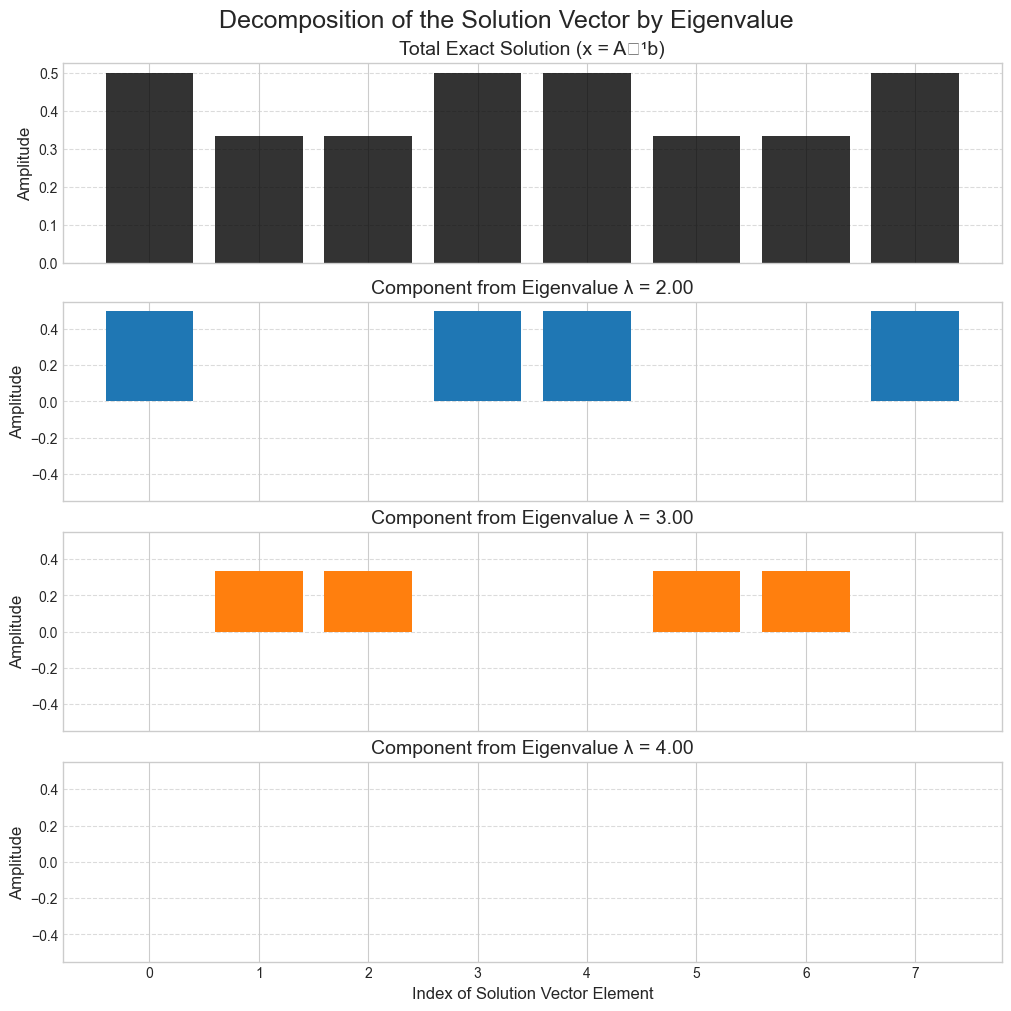

In [265]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_solution_spectrum(matrix_A, vector_b):
    """
    Classically computes the exact solution to Ax=b and decomposes it
    into components based on the eigenvalues of A, with added debugging prints.
    """
    print("--- INSIDE analyze_solution_spectrum ---")
    print(f"Initial shape of matrix_A: {matrix_A.shape}")
    print(f"Initial shape of vector_b: {vector_b.shape}")

    # --- ROBUSTNESS FIX ---
    # Ensure the input vector is a 1D array ('flattened').
    vector_b = vector_b.flatten()
    print(f"Shape of vector_b after flattening: {vector_b.shape}")
    print("-------------------------------------\n")


    if matrix_A.shape[0] != matrix_A.shape[1]:
        raise ValueError("Matrix A must be square.")
    if matrix_A.shape[0] != len(vector_b):
        raise ValueError("Matrix and vector dimensions must match.")

    # Eigendecomposition
    eig_vals, eig_vecs = np.linalg.eig(matrix_A)
    print('Eingenvalues:', eig_vals)
    print('Eingenvectors:', eig_vecs)
    # Change of basis
    betas = np.linalg.inv(eig_vecs) @ vector_b

    # Prepare for component calculation
    unique_eigenvalues = np.unique(np.round(eig_vals, 5))
    component_solutions = {lam: np.zeros_like(vector_b, dtype=complex) for lam in unique_eigenvalues}

    # Calculate individual solution components
    for i in range(len(eig_vals)):
        lam = eig_vals[i]
        beta = betas[i]
        u_vec = eig_vecs[:, i]
        
        key = unique_eigenvalues[np.argmin(np.abs(unique_eigenvalues - lam))]
        
        if abs(lam) > 1e-9:
            component = (beta / lam) * u_vec
            
            # --- DEBUGGING PRINT STATEMENTS ---
            print(f"--- Loop iteration i={i} ---")
            print(f"Eigenvalue (key): {key:.2f}")
            print(f"Shape of component_solutions[key] (left side of +=): {component_solutions[key].shape}")
            print(f"Shape of component (right side of +=):            {component.shape}")
            
            # This is the line that causes the error
            component_solutions[key] += component
            
            print("...addition successful.\n")


    # Calculate the total solution for comparison
    total_exact_solution = np.linalg.solve(matrix_A, vector_b)

    # Plotting
    num_plots = len(unique_eigenvalues) + 1
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, num_plots * 2.5), sharex=True, constrained_layout=True)
    fig.suptitle('Decomposition of the Solution Vector by Eigenvalue', fontsize=18)

    axes[0].bar(range(len(total_exact_solution)), total_exact_solution.real, color='black', alpha=0.8)
    axes[0].set_title('Total Exact Solution (x = A⁻¹b)', fontsize=14)
    axes[0].set_ylabel('Amplitude', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    plot_idx = 1
    max_comp_amp = max([np.max(np.abs(comp.real)) for comp in component_solutions.values()] + [0])
    if max_comp_amp == 0: max_comp_amp = 1.0

    for lam, component_vec in sorted(component_solutions.items()):
        ax = axes[plot_idx]
        ax.bar(range(len(component_vec)), component_vec.real, color=f'C{plot_idx-1}')
        ax.set_title(f'Component from Eigenvalue λ = {lam:.2f}', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_ylim(-max_comp_amp * 1.1, max_comp_amp * 1.1)
        plot_idx += 1

    axes[-1].set_xlabel('Index of Solution Vector Element', fontsize=12)
    plt.show()

# --- Main execution block ---
'''matrix_A = np.array([
	[3., 0., 0., 0., -1, 0., 0., 0.],
	[0., 3., 0., 0., 0., 0., 0., 0.],
	[0., 0., 3., 0., 0., 0., 0., 0.],
	[0., 0., 0., 3., 0., 0., 0., -1],
	[-1, 0., 0., 0., 3., 0., 0., 0.],
	[0., 0., 0., 0., 0., 3., 0., 0.],
	[0., 0., 0., 0., 0., 0., 3., 0.],
	[0., 0., 0., -1, 0., 0., 0., 3.]
])
vector_b = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])'''
    
analyze_solution_spectrum(np.array(matrix_A), np.array(vector_b))

# Classical benchmarking

In [ ]:
%load_ext autoreload
%autoreload 2
from LHCB_Velo_Toy_Models.state_event_generator import *
from LHCB_Velo_Toy_Models import state_event_model 
from LHCB_Velo_Toy_Models.simple_hamiltonian import SimpleHamiltonian
import qiskit
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from hhl_algorithm import HHLAlgorithm as hhl
from hhl_algorithm_1bit import HHLAlgorithm as hhl_1
from LHCB_Velo_Toy_Models.simple_hamiltonian import get_tracks
from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl
import itertools as it

In [ ]:
# --- Constants ---
dz = 20  # mm layer spacing
layers = 5
n_particles = [20, 20, 20, 20, 20]
events = len(n_particles)
n = np.sum(n_particles)

# Detector configuration
module_id = list(range(1, layers + 1))
lx = [33] * layers
ly = [33] * layers
zs = [dz * l for l in range(1, layers + 1)]

# Noise and error parameters
measurement_errors = collision_noises = ghost_rates = drop_rates = np.round(np.linspace(0.00, 0.10, 11), 2)

# Results container
results = []

# --- Main parameter sweep ---
print("Starting parameter sweep...")

for mes_error, coll_noise, ghost, drop in it.product(measurement_errors, collision_noises, ghost_rates, drop_rates):
    print(f"\nRunning simulation with:")
    print(f"  Measurement error = {mes_error}")
    print(f"  Collision noise   = {coll_noise}")
    print(f"  Ghost rate        = {ghost}")
    print(f"  Drop rate         = {drop}")

    # --- Detector setup ---
    Detector = state_event_model.PlaneGeometry(
        module_id=module_id, lx=lx, ly=ly, z=zs
    )

    # --- State event generator setup ---
    state_event_gen = StateEventGenerator(
        Detector,
        events=events,
        n_particles=n_particles,
        measurement_error=mes_error,
        collision_noise=coll_noise
    )

    state_event_gen.generate_random_primary_vertices({'x': 1, 'y': 1, 'z': 1})

    event_particles = [[{'type': 'MIP', 'mass': 0.511, 'q': 1} for _ in range(n)] for _ in range(events)]

    state_event_gen.generate_particles(event_particles)
    event_tracks = state_event_gen.generate_complete_events()

    # --- Inject noise into events ---
    false_tracks = state_event_gen.make_noisy_event(drop_rate=drop, ghost_rate=ghost)

    # --- Hamiltonian setup and solve ---
    ham = SimpleHamiltonian(epsilon=1e-7, gamma=2.0, delta=1.0)
    ham.construct_hamiltonian(event=event_tracks, convolution=True)

    print("Solving classical Hamiltonian...")
    classical_solution = ham.solve_classicaly()
    discretized_solution = (classical_solution > 0.45).astype(int)

    # --- Track reconstruction and validation ---
    rec_tracks = get_tracks(ham, discretized_solution, false_tracks)
    validator = evl(false_tracks, rec_tracks)
    metrics = validator.compute_metrics()

    print(f"  -> Metrics: {metrics}")

    # --- Store result ---
    results.append({
        'measurement_error': mes_error,
        'collision_noise': coll_noise,
        'ghost_rate': ghost,
        'drop_rate': drop,
        'metrics': metrics
    })

print("\nParameter sweep completed. Saving results...")

# --- Save results to JSON file ---
with open("results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Results saved to 'results.json'.")